# 1 - Setup

## 1.1 - Imports & Configs

In [1]:
from utils import *
from matplotlib.ticker import FuncFormatter

## 1.2 - Constants & Globals

In [2]:
OUTPUT_CSV = "./output/csv/"
OUTPUT_GRAPH = "./output/graph/"
df_targets_ext = pd.read_csv("./output/csv/data_clean.csv", sep=';', decimal=',')
sns.set_theme(style="whitegrid")
plt.rcParams["patch.edgecolor"] = "none"
plt.rcParams["patch.linewidth"] = 0
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

# 2 - Visão Geral

## 2.1 - Pergunta 13: Os profissionais da área de dados estão trabalhando em qual modalidade?
O modelo de trabalho mais comum entre os profissionais da área de dados neste dataset é o **100% Remoto**, com **50.5%**.<br>
<br>
*Excluidos entrevistados trabalhando nos cargos: "Outra Opção", "Outras Engenharias (não inclui dev)", "Professor/Pesquisador", "Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas" e "Economista".*

In [3]:
# Excluindo entrevistados que não estão trabalhando ou não responderam a pergunta
df_filtered = df_targets_ext[~df_targets_ext["P2_a Qual sua situação atual de trabalho?"].isin([
    "Desempregado, buscando recolocação",
    "Desempregado e não estou buscando recolocação",
    "Prefiro não informar"
])]
# Selecionando as colunas de interesse, agrupando por modelo de trabalho e cargo atual e somando a quantidade de entrevistados em cada grupo
df_by_work_model = df_filtered[["P0 id", "P2_a Qual sua situação atual de trabalho?", "P2_f Cargo Atual", "P2_r Atualmente qual a sua forma de trabalho?"]].groupby(["P2_r Atualmente qual a sua forma de trabalho?", "P2_f Cargo Atual"]).size().reset_index(name="count")


In [4]:
# Removendo entrevistados que não trabalham na área de dados, agrupando pelo modelo de trabalho e somando a quantidade de entrevistados em cada grupo
grouped_data = df_by_work_model[~df_by_work_model["P2_f Cargo Atual"].isin([
    "Outra Opção",
    "Outras Engenharias (não inclui dev)",
    "Professor/Pesquisador",
    "Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas",
    "Economista"
])].groupby("P2_r Atualmente qual a sua forma de trabalho?").sum().reset_index()
grouped_data = grouped_data.drop(columns=["P2_f Cargo Atual"])
grouped_data = grouped_data.replace({"P2_r Atualmente qual a sua forma de trabalho?": {r"Modelo híbrido flexível.*": "Modelo híbrido flexível"}}, regex=True)
grouped_data



,P2_r Atualmente qual a sua forma de trabalho?,count
0,Modelo 100% presencial,447
1,Modelo 100% remoto,1727
2,Modelo híbrido com dias fixos de trabalho pres...,568
3,Modelo híbrido flexível,680


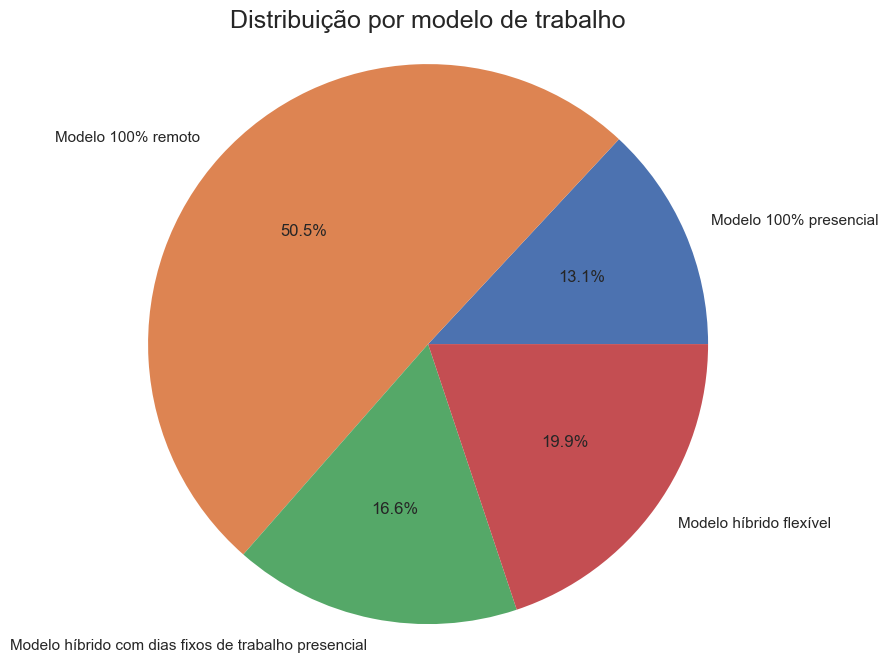

In [5]:
# Plotando o gráfico
plt.figure(figsize=(10, 8))
plt.pie(grouped_data["count"], labels=grouped_data["P2_r Atualmente qual a sua forma de trabalho?"], autopct="%1.1f%%")
plt.title("Distribuição por modelo de trabalho")
plt.axis("equal")
plt.savefig(OUTPUT_GRAPH+"pie_modelo_trabalho.png")
plt.show()

## 2.2 - Pergunta 3: Qual o nível de inglês predominante entre os profissionais mais experientes?
No dataset não há menções ao nível de inglês, porém, com a premissa de que profissionais empregados em empresas estrangeiras possuem uma maior fluencia em inglês, podemos inferir que o mercado externo possui um nível de experiencia proporcionalmente maior, enquanto para o mercado interno é notado o oposto. Vale salientar que a taxa amostral de profissionais que trabalham para empresas estrangeiras é de somente ~1% do total de entrevistados, o que é muito baixo e pode não representar a realidade.

In [6]:
# Seleciona somente os entrevistados que trabalham para empresas estrangeiras
df_abroad = df_targets_ext[df_targets_ext["P2_a Qual sua situação atual de trabalho?"].isin(["Vivo fora do Brasil e trabalho para empresa de fora do Brasil", "Vivo no Brasil e trabalho para empresa de fora do Brasil"])]
df_abroad.shape

(64, 279)

In [7]:
df_abroad.shape[0] / df_targets_ext.shape[0]

0.012091441526544493

In [8]:
# Criando df com a quantidade de pessoas que trabalham fora do brasil
domestic = df_targets_ext[~df_targets_ext["P2_a Qual sua situação atual de trabalho?"].isin(["Vivo fora do Brasil e trabalho para empresa de fora do Brasil", "Vivo no Brasil e trabalho para empresa de fora do Brasil"])][["P0 id", "P2_i Quanto tempo de experiência na área de dados você tem?"]].groupby(["P2_i Quanto tempo de experiência na área de dados você tem?"]).size().reset_index(name="count")
# Criando df com a quantidade de pessoas que trabalham fora do brasil
abroad = df_targets_ext[df_targets_ext["P2_a Qual sua situação atual de trabalho?"].isin(["Vivo fora do Brasil e trabalho para empresa de fora do Brasil", "Vivo no Brasil e trabalho para empresa de fora do Brasil"])][["P0 id", "P2_i Quanto tempo de experiência na área de dados você tem?"]].groupby(["P2_i Quanto tempo de experiência na área de dados você tem?"]).size().reset_index(name="count")
# Calculando a soma total de cada grupo
total_domestic = domestic["count"].sum()
total_abroad = abroad["count"].sum()
# Calculando a proporção de cada faixa de nível de experiência dentro de cada grupo
domestic["Proportion"] = domestic["count"] / total_domestic
abroad["Proportion"] = abroad["count"] / total_abroad
# Une os dois DataFrames na coluna "P2_i Quanto tempo de experiência na área de dados você tem?"
merged_df = pd.merge(domestic, abroad, on="P2_i Quanto tempo de experiência na área de dados você tem?", suffixes=("_domestic", "_abroad"))
# Renomeia as colunas para melhor legibilidade
merged_df.columns = ["Experience", "Count_Domestic", "Proportion_Domestic", "Count_Abroad", "Proportion_Abroad"]
# Seta o index para a coluna "Experience" para facilitar a plotagem
order = ["Mais de 10 anos", "de 7 a 10 anos", "de 5 a 6 anos", "de 4 a 6 anos", "de 3 a 4 anos", "de 1 a 2 anos", "Menos de 1 ano", "Não tenho experiência na área de dados"]
merged_df.set_index("Experience", inplace=True)
# Definir a ordem das categorias
merged_df = merged_df.reindex(order)

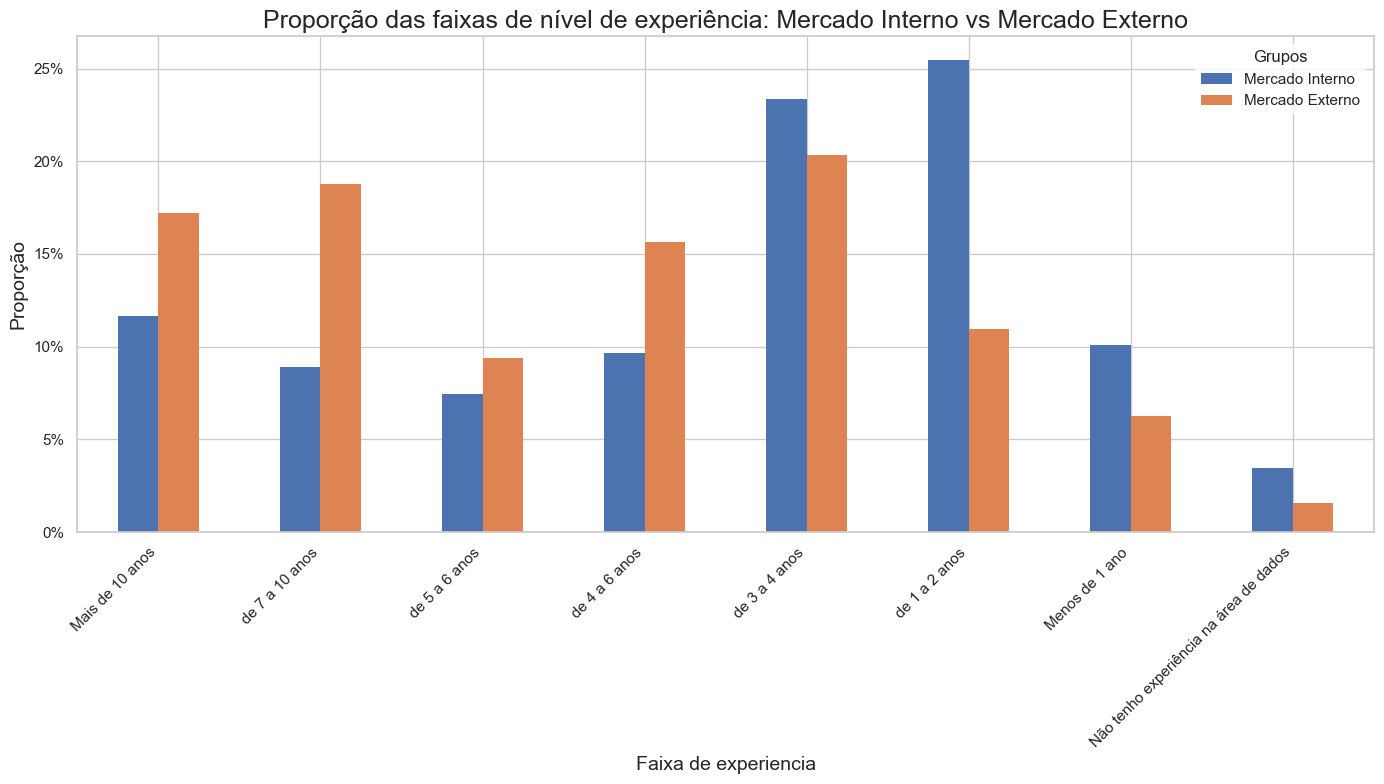

In [9]:
# Plota a proporção de cada faixa de nível de experiência para ambos os grupos
merged_df[["Proportion_Domestic", "Proportion_Abroad"]].plot(kind="bar", figsize=(14, 8))
plt.title("Proporção das faixas de nível de experiência: Mercado Interno vs Mercado Externo")
plt.xlabel("Faixa de experiencia")
plt.ylabel("Proporção")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Grupos", labels=["Mercado Interno", "Mercado Externo"])
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.tight_layout()
plt.savefig(OUTPUT_GRAPH+"experiencia_mercado_interno_vs_externo.png")
plt.show()

## 2.3 Pergunta 1: Quais estados concentram os profissionais com mais conhecimento em Python e SQL?
SP é a que concentra mais profissionais com conhecimento em Python e SQL em total de pessoas, porem MG, RJ e PR também possuem uma quantidade de profissionais significativas e um nivel de conhecimento nas duas linguagens proporcionalmente maior. Também pode-se notar que Python é a linguagem mais desenvolvida.<br>
<br>
*OBS: 
- Para calcular a dominancia de uma linguagem foi calculado um valor entre 0 e 1, onde 0 = não domina; 0.6 = domina; 1 = domina completamente. 
- Foram utilizadas as respostas as seguintes perguntas com os seus respectivos pesos:
    - "P4_d Quais das linguagens listadas abaixo você utiliza no trabalho?", com um peso de 0.4.
    - "P4_e Entre as linguagens listadas abaixo, qual é a que você mais utiliza no trabalho?", com um peso de 0.3.
    - P4_f Entre as linguagens listadas abaixo, qual é a sua preferida?", com um peso de 0.3.
- A segunda tabela representa a proporção de cada estado em relação ao total de pessoas que sabem programar em Python, SQL e em ambos, mostrado em porcentagem. 50% significa que ná média todos dominam determinada linguagem, 100% significa que todos tem o nivel máximo de dominancia.*

In [10]:
# Seleciona as colunas que referenciam Python ou SQL
cols_prog_langs = [col for col in df_targets_ext.columns if "python" in col.lower() or "sql" in col.lower() or "linguagens" in col.lower()]
# Cria um DataFrame com a coluna "P0 id" e as colunas de linguagens de programação ao DataFrame
df_prog_langs = df_targets_ext[["P0 id"] + cols_prog_langs[:4]]
# Hot Encoding para as colunas de linguagens de programação
df_prog_langs = pd.get_dummies(df_prog_langs, columns=cols_prog_langs[:4], drop_first=True, dtype=float)
# Seleciona somente as colunas criadas pelo hot encoding que mencionam Python ou SQL
cols_prog_langs = [col for col in df_prog_langs.columns if "python" in col.lower() or "sql" in col.lower()]
# Dropa as colunas do DataFrame que não serão utilizadas
df_prog_langs = df_prog_langs[["P0 id"] + cols_prog_langs]
# Calcula o conhecimento de cada linguagem de programação para um número entre 0 e 1 para cada profissional
weights = [0.4, 0.3, 0.3]
df_prog_langs["Nivel_SQL"] = (df_prog_langs["P4_d_1 SQL_1.0"] * weights[0] + df_prog_langs["P4_e Entre as linguagens listadas abaixo, qual é a que você mais utiliza no trabalho?_SQL"] * weights[1] + df_prog_langs["P4_f Entre as linguagens listadas abaixo, qual é a sua preferida?_SQL"] * weights[2])
df_prog_langs["Nivel_Python"] = (df_prog_langs["P4_d_3 Python_1.0"] * weights[0] + df_prog_langs["P4_e Entre as linguagens listadas abaixo, qual é a que você mais utiliza no trabalho?_Python"] * weights[1] + df_prog_langs["P4_f Entre as linguagens listadas abaixo, qual é a sua preferida?_Python"] * weights[2])
# Dropa as colunas que não serão mais usadas
df_prog_langs.drop(columns=df_prog_langs.columns[1:7], inplace=True)
# Define se um profissional domina uma linguagem de programação ou não, com base em um limiar
df_prog_langs["Domina_SQL"] = (df_prog_langs["Nivel_SQL"] > 0.5).astype(int)
df_prog_langs["Domina_Python"] = (df_prog_langs["Nivel_Python"] > 0.5).astype(int)
# Adiciona o valor da UF onde reside e a faixa de idade para cada profissional
df_prog_langs["UF"] = df_targets_ext["P1_i_1 uf onde mora"]
df_prog_langs["Idade"] = df_targets_ext["P1_a_1 Faixa idade"]
df_prog_langs

,P0 id,Nivel_SQL,Nivel_Python,Domina_SQL,Domina_Python,UF,Idade
0,001b2d1qtli8t9z7oqgdhj001b2d4i0g,0.4,1.0,0,1,MG,30-34
1,0026aa3fwd78u0026asg7456tfkjg2cs,0.7,0.7,1,1,ES,30-34
2,00r21rb9pusd1b0v7ew00r21rw3dy69w,0.7,0.7,1,1,SP,35-39
3,00urm3jf2cek12w6ygue00urm3jzd17j,0.0,0.0,0,0,SP,22-24
4,00v0az4g792svil00vn6y1kfm9hq8vy9,0.4,1.0,0,1,MG,30-34
...,...,...,...,...,...,...,...
5288,zyg9519671iqrgy93qzyg95183k8ix5f,0.0,0.0,0,0,MG,30-34
5289,zyppgxzxko25qkgwsbrgpzyppgxzxs81,0.4,1.0,0,1,RN,30-34
5290,zysl5f50cnz3r0cbe6t2zysrxbzfsrng,0.4,1.0,0,1,SP,25-29
5291,zyt2656c9e1becxp457zyt26566dsng8,0.0,0.0,0,0,SP,30-34


In [11]:
# Soma a quantidade de profissionais que dominam cada linguagem em cada UF
dominancia_count = df_prog_langs.groupby("UF").agg({"Domina_SQL": "sum", "Domina_Python": "sum", "P0 id": "count"})
cols = [col for col in dominancia_count.columns if col.startswith("Domina_")]
dominancia_count["Total"] = dominancia_count[cols].sum(axis=1)
dominancia_count = dominancia_count.sort_values(ascending=False, by="Total").reset_index()
dominancia_count = dominancia_count.rename(columns={"P0 id": "Total_Pessoas"})
# Soma os valores de dominancia para cada UF
dominancia_sum = df_prog_langs.groupby("UF").agg({"Nivel_SQL": "sum", "Nivel_Python": "sum"})
cols = [col for col in dominancia_sum.columns if col.startswith("Nivel_")]
dominancia_sum["Total"] = dominancia_sum[cols].sum(axis=1)
dominancia_sum = dominancia_sum.sort_values(ascending=False, by="Total").reset_index()
# Une as duas tabelas
df_prog_langs_ext = pd.merge(dominancia_sum, dominancia_count, on="UF", suffixes=('_nivel', '_pessoas_dominantes'))
# Calcula valores em porcentagem (nivel / (total de pessoas * 2), pois o limiar sendo 50%, se não dobrar as pessoas o valor em porcentagem chega a 200%. Já em Nivel total é * 4 pois soma os valores de dominancia das duas linguagens.)
for col in cols:
    df_prog_langs_ext[f"{col}_%"] = calc_percent(df_prog_langs_ext[col], df_prog_langs_ext["Total_Pessoas"] * 2)
df_prog_langs_ext["Nivel_Total_%"] = calc_percent(df_prog_langs_ext["Total_nivel"], df_prog_langs_ext["Total_Pessoas"] * 4)
# Exibe a tabela
df_prog_langs_ext

,UF,Nivel_SQL,Nivel_Python,Total_nivel,Domina_SQL,Domina_Python,Total_Pessoas,Total_pessoas_dominantes,Nivel_SQL_%,Nivel_Python_%,Nivel_Total_%
0,SP,700.7,970.5,1671.2,696,1026,2073,1722,0.169006,0.234081,0.201544
1,MG,195.0,268.8,463.8,188,285,557,473,0.175045,0.241293,0.208169
2,PR,165.6,219.8,385.4,170,236,420,406,0.197143,0.261667,0.229405
3,RJ,154.4,209.1,363.5,144,215,437,359,0.176659,0.239245,0.207952
4,RS,103.4,129.6,233.0,110,136,291,246,0.177663,0.222680,0.200172
5,SC,97.1,127.1,224.2,102,138,250,240,0.194200,0.254200,0.224200
6,DF,52.7,83.8,136.5,44,86,175,130,0.150571,0.239429,0.195000
7,BA,46.5,63.2,109.7,45,64,155,109,0.150000,0.203871,0.176935
8,PE,46.1,61.9,108.0,51,67,124,118,0.185887,0.249597,0.217742
9,CE,45.0,61.9,106.9,45,67,134,112,0.167910,0.230970,0.199440


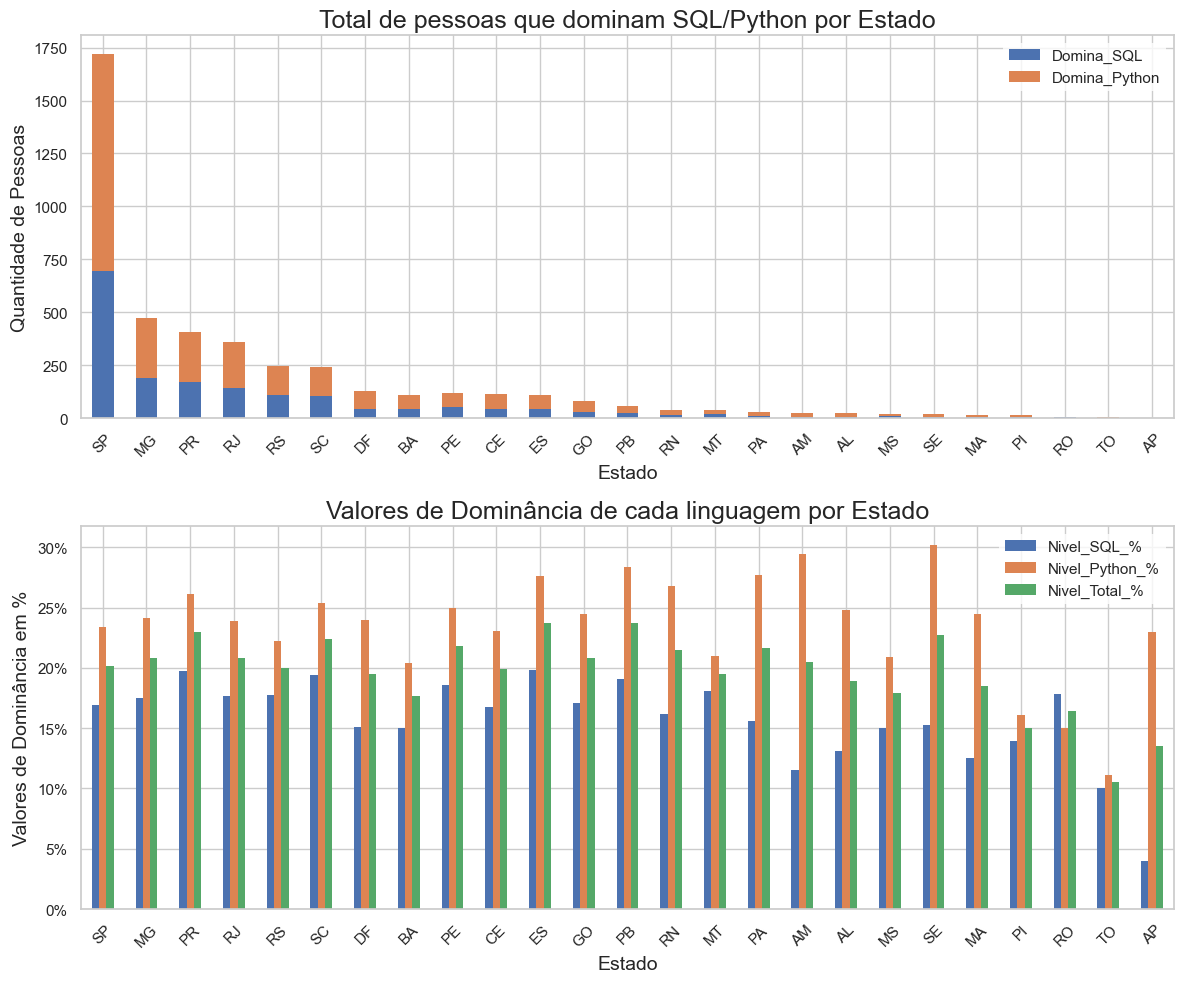

In [12]:
# Plotar gráficos
# Gráfico de barras para a quantidade de pessoas que dominam cada linguagem
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
cols = [col for col in df_prog_langs_ext.columns if col.startswith("Domina_")]
df_prog_langs_ext[['UF'] + cols].plot(kind='bar', stacked=True, x='UF', ax=ax[0])
ax[0].set_title("Total de pessoas que dominam SQL/Python por Estado")
ax[0].set_ylabel("Quantidade de Pessoas")
ax[0].set_xlabel("Estado")
ax[0].tick_params(axis='x', rotation=45)
# Gráfico de barras para a soma dos valores de dominância de cada linguagem
cols = [col for col in df_prog_langs_ext.columns if col.endswith("%")]
df_prog_langs_ext[['UF'] + cols].plot(kind="bar", x="UF", ax=ax[1])
ax[1].set_title("Valores de Dominância de cada linguagem por Estado")
ax[1].set_ylabel("Valores de Dominância em %")
ax[1].set_xlabel("Estado")
ax[1].tick_params(axis='x', rotation=45)
ax[1].yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.tight_layout()
plt.savefig(OUTPUT_GRAPH+"bar_dominancia_linguagens_por_UF.png")
plt.show()

## 2.4 - Pergunta 2: Existe correlação entre idade e domínio de ferramentas como Power BI e Tableau?
O gráfico de correlação mostra que há uma correlação negativa, quanto mais velho, menos domínio das ferramentas de BI. Já o gráfico de barras mostra que há uma faixa de idade onde o domínio é subtancialmente maior: entre 25 e 34 anos.
*OBS:
- Para calcular a dominancia de uma ferramenta foi calculado um valor entre 0 e 1, onde 0 = não domina; 0.6 = domina; 1 = domina completamente. Foram utilizadas as respostas as seguintes perguntas com os seus respectivos pesos:
    - "P4_j Ferramenta de BI utilizada no dia a dia", com um peso de 0.5.
    - "P4_k Qual sua ferramenta de BI preferida?", com um peso de 0.5.
- A tabela com as proporções em porcentagem representa a proporção de cada faixa de idade em relação ao total de pessoas que sabem determinada ferramenta e o total. 50% significa que na média todos dominam determinada linguagem, 100% significa que todos tem o nivel máximo de dominancia.*
*

In [13]:
# Seleciona as colunas que mencionam ferramentas de BI
cols_bi_tools = [col for col in df_targets_ext.columns if re.match(r"P4_j_\d+", col) or re.match(r"P4_k+", col)]
# Cria um DataFrame com as colunas de BI e a coluna de idade
df_bi_tools = df_targets_ext[["P0 id"] + cols_bi_tools]
# Hot Encoding das colunas que referenciam ferramentas de BI
df_bi_tools = pd.get_dummies(df_bi_tools, columns=["P4_k Qual sua ferramenta de BI preferida?"], drop_first=True, dtype=float)
# Une e dropa algumas colunas duplicadas
df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Grafana"] += df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Graphana"]
df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Excel"] += df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Spreadsheet"]
df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Looker Studio"] += df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Google Looker Studio"]
df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Looker Studio"] += df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Looker studio"]
df_bi_tools.drop(columns=["P4_k Qual sua ferramenta de BI preferida?_Graphana", "P4_k Qual sua ferramenta de BI preferida?_Spreadsheet", "P4_k Qual sua ferramenta de BI preferida?_Google Looker Studio", "P4_k Qual sua ferramenta de BI preferida?_Looker studio"], inplace=True)
# Soma os valores de todas as colunas criadas pelo Hot Encoding e dropa as que tiverem valor < 100 com algumas exceções
sums = df_bi_tools[df_bi_tools.columns[3:]].sum()
cols_to_drop = sums[sums < 90].index.difference(["P4_k Qual sua ferramenta de BI preferida?_Excel", "P4_k Qual sua ferramenta de BI preferida?_Grafana", "P4_k Qual sua ferramenta de BI preferida?_Alteryx", "P4_k Qual sua ferramenta de BI preferida?_Looker Studio", "P4_k Qual sua ferramenta de BI preferida?_Pentaho", "P4_k Qual sua ferramenta de BI preferida?_Qlik View/Qlik Sense"])
df_bi_tools = df_bi_tools.drop(columns=cols_to_drop)
# Calcula o conhecimento de cada ferramenta de BI para um número entre 0 e 1 para cada profissional
weights = [0.5, 0.5]
df_bi_tools["Nivel_PowerBI"] = (df_bi_tools["P4_j_1 Microsoft PowerBI"] * weights[0] + df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Microsoft PowerBI"] * weights[1])
df_bi_tools["Nivel_Qlik"] = (df_bi_tools["P4_j_2 Qlik View/Qlik Sense"] * weights[0] + df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Qlik View/Qlik Sense"] * weights[1])
df_bi_tools["Nivel_Tableau"] = (df_bi_tools["P4_j_3 Tableau"] * weights[0] + df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Tableau"] * weights[1])
df_bi_tools["Nivel_Metabase"] = (df_bi_tools["P4_j_4 Metabase"] * weights[0] + df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Metabase"] * weights[1])
df_bi_tools["Nivel_Looker"] = (df_bi_tools["P4_j_7 Looker"] * weights[0] + df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Looker"] * weights[1])
df_bi_tools["Nivel_Looker_Studio"] = (df_bi_tools["P4_j_8 Looker Studio(Google Data Studio)"] * weights[0] + df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Looker Studio"] * weights[1])
df_bi_tools["Nivel_Amazon_Quicksight"] = (df_bi_tools["P4_j_9 Amazon Quicksight"] * weights[0] + df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Amazon Quicksight"] * weights[1])
df_bi_tools["Nivel_Alteryx"] = (df_bi_tools["P4_j_11 Alteryx"] * weights[0] + df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Alteryx"] * weights[1])
df_bi_tools["Nivel_Grafana"] = (df_bi_tools["P4_j_19 Grafana"] * weights[0] + df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Grafana"] * weights[1])
df_bi_tools["Nivel_Pentaho"] = (df_bi_tools["P4_j_21 Pentaho"] * weights[0] + df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Pentaho"] * weights[1])
df_bi_tools["Nivel_Excel"] = (df_bi_tools["P4_j_22 Fazemos todas as análises utilizando apenas Excel ou planilhas do google"] * weights[0] + df_bi_tools["P4_k Qual sua ferramenta de BI preferida?_Excel"] * weights[1])
# Dropa as colunas que não serão mais necessarias
cols_to_drop = df_bi_tools.columns[1:23]
df_bi_tools.drop(columns=cols_to_drop, inplace=True)
# Define se um profissional domina uma linguagem de programação ou não, com base em um limiar
df_bi_tools["Domina_PowerBI"] = (df_bi_tools["Nivel_PowerBI"] > 0.5).astype(int)
df_bi_tools["Domina_Qlik"] = (df_bi_tools["Nivel_Qlik"] > 0.5).astype(int)
df_bi_tools["Domina_Tableau"] = (df_bi_tools["Nivel_Tableau"] > 0.5).astype(int)
df_bi_tools["Domina_Metabase"] = (df_bi_tools["Nivel_Metabase"] > 0.5).astype(int)
df_bi_tools["Domina_Looker"] = (df_bi_tools["Nivel_Looker"] > 0.5).astype(int)
df_bi_tools["Domina_Looker_Studio"] = (df_bi_tools["Nivel_Looker_Studio"] > 0.5).astype(int)
df_bi_tools["Domina_Amazon_Quicksight"] = (df_bi_tools["Nivel_Amazon_Quicksight"] > 0.5).astype(int)
df_bi_tools["Domina_Alteryx"] = (df_bi_tools["Nivel_Alteryx"] > 0.5).astype(int)
df_bi_tools["Domina_Grafana"] = (df_bi_tools["Nivel_Grafana"] > 0.5).astype(int)
df_bi_tools["Domina_Pentaho"] = (df_bi_tools["Nivel_Pentaho"] > 0.5).astype(int)
df_bi_tools["Domina_Excel"] = (df_bi_tools["Nivel_Excel"] > 0.5).astype(int)
# Adiciona o valor da UF onde reside e a faixa de idade para cada profissional
df_bi_tools["UF"] = df_targets_ext["P1_i_1 uf onde mora"]
df_bi_tools["Idade"] = df_targets_ext["P1_a_1 Faixa idade"]
df_bi_tools

,P0 id,Nivel_PowerBI,Nivel_Qlik,Nivel_Tableau,Nivel_Metabase,Nivel_Looker,Nivel_Looker_Studio,Nivel_Amazon_Quicksight,Nivel_Alteryx,Nivel_Grafana,...,Domina_Metabase,Domina_Looker,Domina_Looker_Studio,Domina_Amazon_Quicksight,Domina_Alteryx,Domina_Grafana,Domina_Pentaho,Domina_Excel,UF,Idade
0,001b2d1qtli8t9z7oqgdhj001b2d4i0g,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,MG,30-34
1,0026aa3fwd78u0026asg7456tfkjg2cs,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,ES,30-34
2,00r21rb9pusd1b0v7ew00r21rw3dy69w,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.5,0.0,...,0,0,0,1,0,0,0,0,SP,35-39
3,00urm3jf2cek12w6ygue00urm3jzd17j,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,SP,22-24
4,00v0az4g792svil00vn6y1kfm9hq8vy9,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,MG,30-34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5288,zyg9519671iqrgy93qzyg95183k8ix5f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,MG,30-34
5289,zyppgxzxko25qkgwsbrgpzyppgxzxs81,0.0,0.0,1.0,0.0,0.5,0.5,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,RN,30-34
5290,zysl5f50cnz3r0cbe6t2zysrxbzfsrng,0.0,0.0,0.5,0.0,0.5,0.5,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,SP,25-29
5291,zyt2656c9e1becxp457zyt26566dsng8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,SP,30-34


In [14]:
# Soma a quantidade de profissionais que dominam cada linguagem em cada UF
dominancia_count = df_bi_tools.groupby("Idade").agg({"Domina_PowerBI": "sum", "Domina_Qlik": "sum", "Domina_Tableau": "sum", "Domina_Metabase": "sum", "Domina_Looker": "sum", "Domina_Looker_Studio": "sum", "Domina_Amazon_Quicksight": "sum", "Domina_Alteryx": "sum", "Domina_Grafana": "sum", "Domina_Pentaho": "sum", "Domina_Excel": "sum", "P0 id": "count"})
cols = [col for col in dominancia_count.columns if col.startswith("Domina_")]
cols_to_group = [col for col in cols if dominancia_count[col].sum() < 100]
cols = list(set(cols) - set(cols_to_group))
# Agrupa as colunas de baixo valor em nova coluna
dominancia_count["Domina_Outras"] = dominancia_count[cols_to_group].sum(axis=1)
# Dropa as colunas que foram usadas para criar a nova coluna
dominancia_count.drop(columns=cols_to_group, inplace=True)
# Soma os valores a quantidade de pessoas para cada ferramenta
dominancia_count["Total"] = dominancia_count[cols].sum(axis=1)
dominancia_count = dominancia_count.sort_values(ascending=False, by="Total").reset_index()
dominancia_count = dominancia_count.rename(columns={"P0 id": "Total_Pessoas"})
# Soma os valores de dominancia para cada faixa de idade
dominancia_sum = df_bi_tools.groupby("Idade").agg({"Nivel_PowerBI": "sum", "Nivel_Qlik": "sum", "Nivel_Tableau": "sum", "Nivel_Metabase": "sum", "Nivel_Looker": "sum", "Nivel_Looker_Studio": "sum", "Nivel_Amazon_Quicksight": "sum", "Nivel_Alteryx": "sum", "Nivel_Grafana": "sum", "Nivel_Pentaho": "sum", "Nivel_Excel": "sum"})
cols_to_group = [col.replace('Domina_', 'Nivel_') if col.startswith('Domina_') else col for col in cols_to_group]
cols = list(set([col for col in dominancia_sum.columns if col.startswith("Nivel_")]) - set(cols_to_group))
# Agrupa as colunas de baixo valor em nova coluna
dominancia_sum["Nivel_Outras"] = dominancia_sum[cols_to_group].sum(axis=1)
cols.append("Nivel_Outras")
# Dropa as colunas que foram usadas para criar a nova coluna
dominancia_sum.drop(columns=cols_to_group, inplace=True)
# Soma os valores de dominancia para cada ferramenta
dominancia_sum["Total"] = dominancia_sum[cols].sum(axis=1)
dominancia_sum = dominancia_sum.sort_values(ascending=False, by="Total").reset_index()
# Une as duas tabelas
df_bi_tools_ext = pd.merge(dominancia_sum, dominancia_count, on="Idade", suffixes=('_nivel', '_ferramentas_dominadas'))
# Calcula valores em porcentagem (nivel / (total de pessoas * 2), pois o limiar sendo 50%, se não dobrar as pessoas o valor em porcentagem chega a 200% Já em Nivel total é * 4 pois soma os valores de dominancia das duas linguagens.)
for col in cols:
    df_bi_tools_ext[f"{col}_%"] = calc_percent(df_bi_tools_ext[col], df_bi_tools_ext["Total_Pessoas"] * 2)
df_bi_tools_ext["Nivel_Total_%"] = calc_percent(df_bi_tools_ext["Total_nivel"], df_bi_tools_ext["Total_Pessoas"] * 4)
# Exibe a tabela
df_bi_tools_ext

,Idade,Nivel_PowerBI,Nivel_Tableau,Nivel_Looker,Nivel_Outras,Total_nivel,Domina_PowerBI,Domina_Tableau,Domina_Looker,Total_Pessoas,Domina_Outras,Total_ferramentas_dominadas,Nivel_Looker_%,Nivel_Tableau_%,Nivel_PowerBI_%,Nivel_Outras_%,Nivel_Total_%
0,25-29,777.0,219.5,241.0,477.5,1715.0,588,90,97,1654,75,775,0.072854,0.066354,0.234885,0.144347,0.259220
1,30-34,565.0,184.0,181.5,354.0,1284.5,430,76,70,1377,57,576,0.065904,0.066812,0.205156,0.128540,0.233206
2,35-39,311.0,88.0,79.0,183.5,661.5,240,34,28,790,25,302,0.050000,0.055696,0.196835,0.116139,0.209335
3,22-24,275.5,54.0,54.5,137.0,521.0,222,17,20,493,18,259,0.055274,0.054767,0.279412,0.138945,0.264199
4,40-44,153.0,48.0,31.5,87.0,319.5,115,27,11,429,14,153,0.036713,0.055944,0.178322,0.101399,0.186189
5,17-21,82.0,11.5,11.0,28.0,132.5,66,5,3,178,3,74,0.030899,0.032303,0.230337,0.078652,0.186096
6,45-49,54.5,13.0,10.5,28.0,106.0,40,3,3,189,1,46,0.027778,0.034392,0.144180,0.074074,0.140212
7,50-54,24.5,7.0,6.0,16.5,54.0,17,3,1,111,3,21,0.027027,0.031532,0.110360,0.074324,0.121622
8,55+,19.5,8.0,1.5,5.5,34.5,14,4,0,72,0,18,0.010417,0.055556,0.135417,0.038194,0.119792


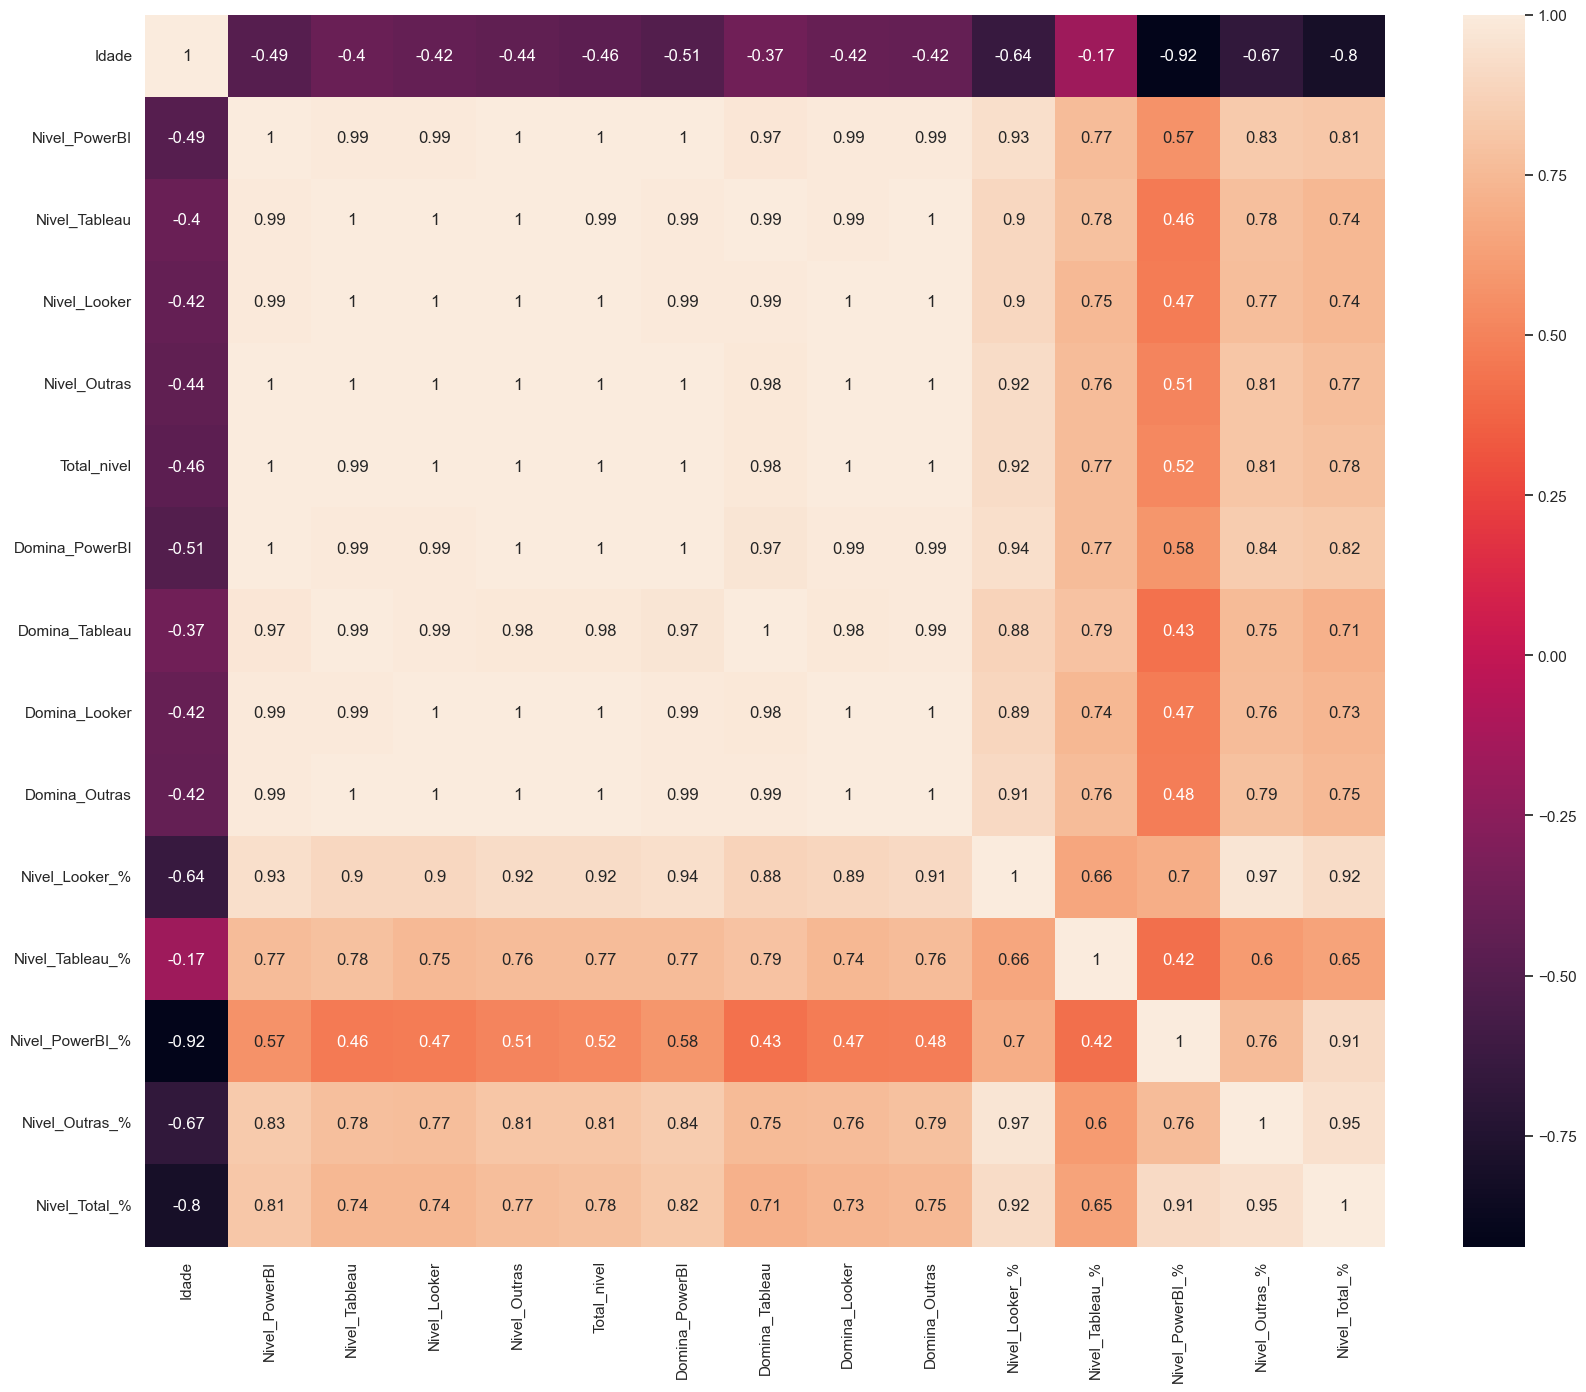

In [15]:
df_aux = df_bi_tools_ext.copy()
df_aux["Idade"] = df_aux["Idade"].replace({'25-29': 3, '30-34': 4, '35-39': 5, '22-24': 2, '40-44': 6, '17-21': 1, '45-49': 7, '50-54': 8, '55+': 9}).astype(int)
corr(df_aux.drop(columns=["Total_Pessoas", "Total_ferramentas_dominadas"]))

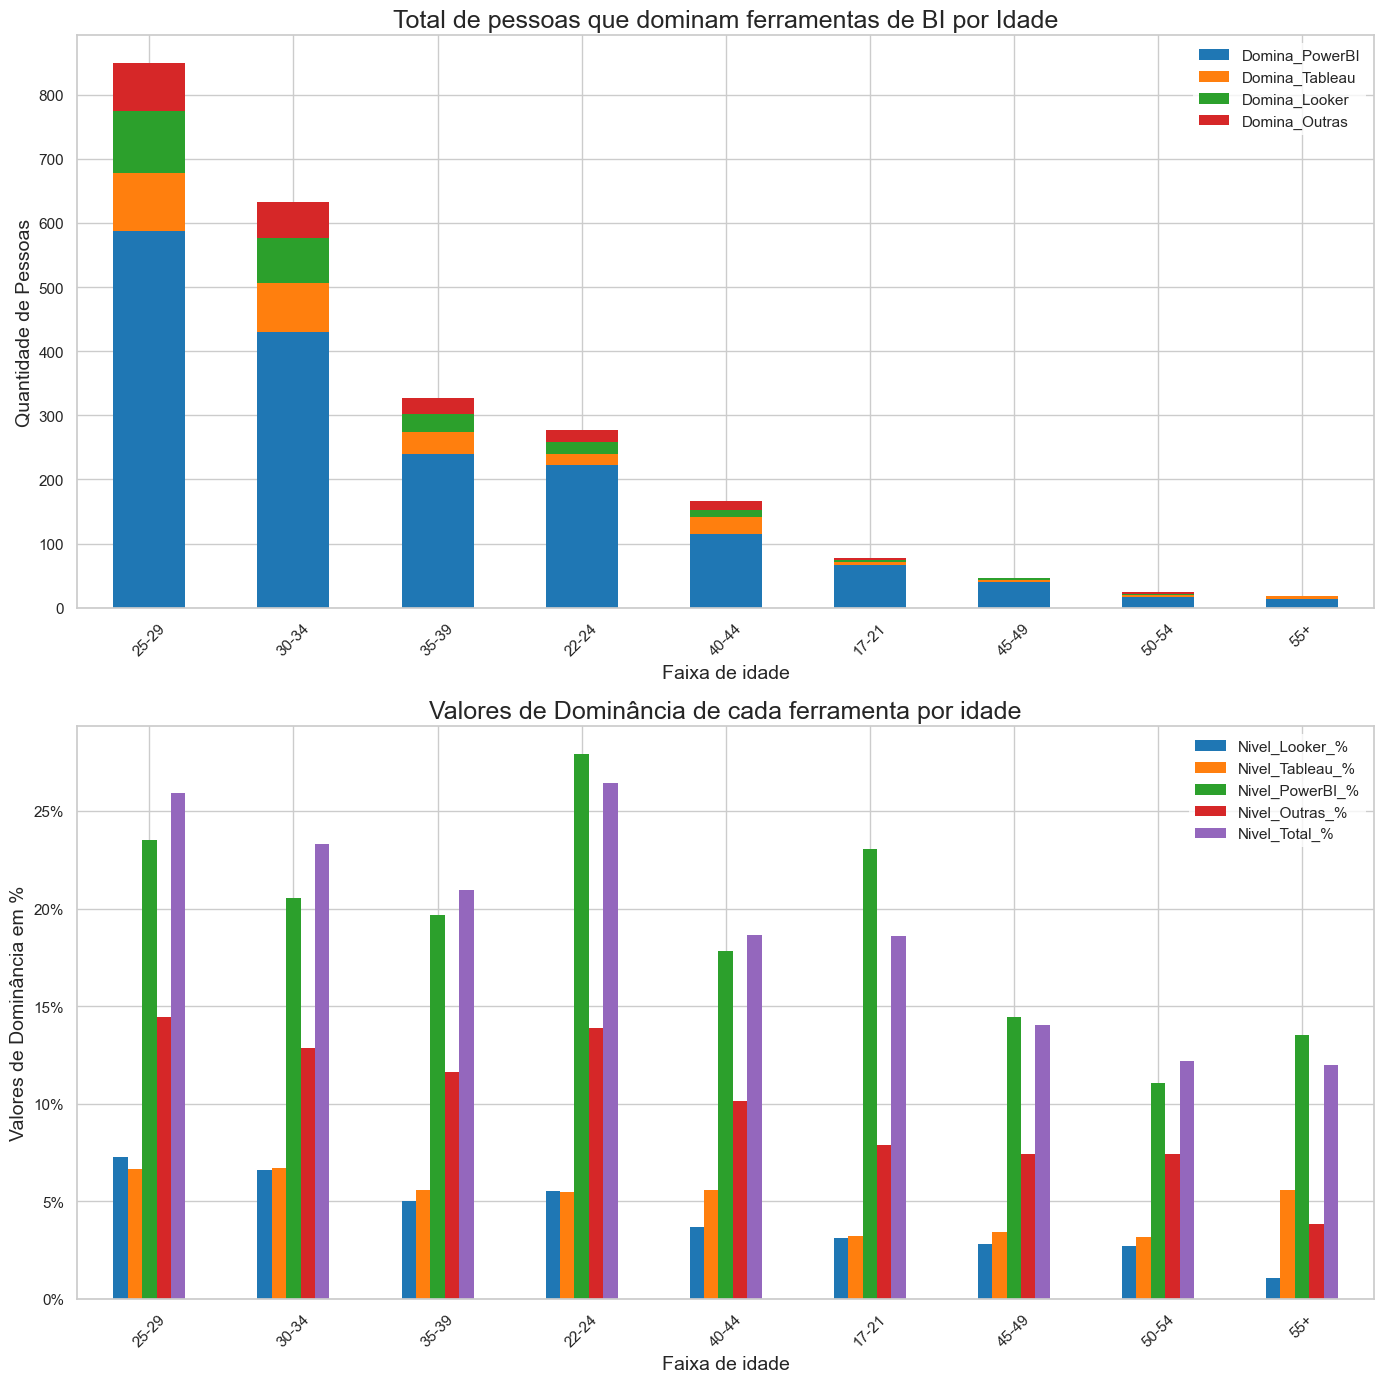

In [16]:
# Plotar gráficos
# Gráfico de barras para a quantidade de pessoas que dominam cada ferramenta
fig, ax = plt.subplots(2, 1, figsize=(14, 14))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#aec7e8", "#502E58"]
cols = [col for col in df_bi_tools_ext.columns if col.startswith("Domina_")]
df_bi_tools_ext[["Idade"] + cols].plot(kind='bar', stacked=True, x='Idade', ax=ax[0], color=colors)
ax[0].set_title("Total de pessoas que dominam ferramentas de BI por Idade")
ax[0].set_ylabel("Quantidade de Pessoas")
ax[0].set_xlabel("Faixa de idade")
ax[0].tick_params(axis='x', rotation=45)
# Gráfico de barras para a soma dos valores de dominância de cada ferramenta
cols = [col for col in df_bi_tools_ext.columns if col.endswith("%")]
df_bi_tools_ext[["Idade"] + cols].plot(kind="bar", x="Idade", ax=ax[1], color=colors)
ax[1].set_title("Valores de Dominância de cada ferramenta por idade")
ax[1].set_ylabel("Valores de Dominância em %")
ax[1].set_xlabel("Faixa de idade")
ax[1].tick_params(axis='x', rotation=45)
ax[1].yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.tight_layout()
plt.savefig(OUTPUT_GRAPH+"bar_dominancia_ferramentas_bi_por_idade.png")
plt.show()

# 3 - Visão Alvos de Contratação

In [17]:
# Criar df apenas de analistas de dados
df_targets = df_targets_ext[df_targets_ext["P2_f Cargo Atual"] == "Analista de Dados/Data Analyst"]
# Dropar colunas com 100% de valores nulos
df_targets = df_targets.dropna(axis=1, how='all')

In [18]:
# Criar df de analistas de dados + outros cargos que podem ocupar a mesma vaga
df_targets_ext = df_targets_ext[df_targets_ext["P2_f Cargo Atual"].isin(["Analista de Dados/Data Analyst", "Analista de BI/BI Analyst", "Cientista de Dados/Data Scientist"])]
# Dropar colunas com 100% de valores nulos
df_targets = df_targets.dropna(axis=1, how='all')
df_targets_ext.shape

(2100, 279)

In [19]:
# Cria a tabela referente a linguagens de programação só para os alvos da contratação
cols_prog_langs = [col for col in df_targets_ext.columns if "python" in col.lower() or "sql" in col.lower() or "linguagens" in col.lower()]
df_prog_langs_target = df_targets_ext[["P0 id"] + cols_prog_langs[:4]]
df_prog_langs_target = pd.get_dummies(df_prog_langs_target, columns=cols_prog_langs[:4], drop_first=True, dtype=float)
cols_prog_langs = [col for col in df_prog_langs_target.columns if "python" in col.lower() or "sql" in col.lower()]
df_prog_langs_target = df_prog_langs_target[["P0 id"] + cols_prog_langs]
weights = [0.4, 0.3, 0.3]
df_prog_langs_target["Nivel_SQL"] = (df_prog_langs_target["P4_d_1 SQL_1.0"] * weights[0] + df_prog_langs_target["P4_e Entre as linguagens listadas abaixo, qual é a que você mais utiliza no trabalho?_SQL"] * weights[1] + df_prog_langs_target["P4_f Entre as linguagens listadas abaixo, qual é a sua preferida?_SQL"] * weights[2])
df_prog_langs_target["Nivel_Python"] = (df_prog_langs_target["P4_d_3 Python_1.0"] * weights[0] + df_prog_langs_target["P4_e Entre as linguagens listadas abaixo, qual é a que você mais utiliza no trabalho?_Python"] * weights[1] + df_prog_langs_target["P4_f Entre as linguagens listadas abaixo, qual é a sua preferida?_Python"] * weights[2])
df_prog_langs_target.drop(columns=df_prog_langs_target.columns[1:7], inplace=True)
df_prog_langs_target["Domina_SQL"] = (df_prog_langs_target["Nivel_SQL"] > 0.5).astype(int)
df_prog_langs_target["Domina_Python"] = (df_prog_langs_target["Nivel_Python"] > 0.5).astype(int)
df_prog_langs_target["UF"] = df_targets_ext["P1_i_1 uf onde mora"]
df_prog_langs_target["Idade"] = df_targets_ext["P1_a_1 Faixa idade"]
dominancia_count = df_prog_langs_target.groupby("UF").agg({"Domina_SQL": "sum", "Domina_Python": "sum", "P0 id": "count"})
cols = [col for col in dominancia_count.columns if col.startswith("Domina_")]
dominancia_count["Total"] = dominancia_count[cols].sum(axis=1)
dominancia_count = dominancia_count.sort_values(ascending=False, by="Total").reset_index()
dominancia_count = dominancia_count.rename(columns={"P0 id": "Total_Pessoas"})
dominancia_sum = df_prog_langs_target.groupby("UF").agg({"Nivel_SQL": "sum", "Nivel_Python": "sum"})
cols = [col for col in dominancia_sum.columns if col.startswith("Nivel_")]
dominancia_sum["Total"] = dominancia_sum[cols].sum(axis=1)
dominancia_sum = dominancia_sum.sort_values(ascending=False, by="Total").reset_index()
df_prog_langs_target_ext = pd.merge(dominancia_sum, dominancia_count, on="UF", suffixes=('_nivel', '_pessoas_dominantes'))
for col in cols:
    df_prog_langs_target_ext[f"{col}_%"] = calc_percent(df_prog_langs_target_ext[col], df_prog_langs_target_ext["Total_Pessoas"] * 2)
df_prog_langs_target_ext["Nivel_Total_%"] = calc_percent(df_prog_langs_target_ext["Total_nivel"], df_prog_langs_target_ext["Total_Pessoas"] * 4)

In [20]:
# Cria a tabela referente a ferramentas de BI só para alvos da contratação
cols_bi_tools = [col for col in df_targets_ext.columns if re.match(r"P4_j_\d+", col) or re.match(r"P4_k+", col)]
df_bi_tools_targets = df_targets_ext[["P0 id"] + cols_bi_tools]
df_bi_tools_targets = pd.get_dummies(df_bi_tools_targets, columns=["P4_k Qual sua ferramenta de BI preferida?"], drop_first=True, dtype=float)
df_bi_tools_targets["P4_k Qual sua ferramenta de BI preferida?_Looker Studio"] += df_bi_tools_targets["P4_k Qual sua ferramenta de BI preferida?_Google Looker Studio"]
df_bi_tools_targets.drop(columns=["P4_k Qual sua ferramenta de BI preferida?_Google Looker Studio"], inplace=True)
sums = df_bi_tools_targets[df_bi_tools_targets.columns[3:]].sum()
cols_to_drop = sums[sums < 90].index.difference([
    "P4_k Qual sua ferramenta de BI preferida?_Metabase", "P4_k Qual sua ferramenta de BI preferida?_Qlik View/Qlik Sense", "P4_k Qual sua ferramenta de BI preferida?_Looker Studio", "P4_k Qual sua ferramenta de BI preferida?_Grafana", "P4_k Qual sua ferramenta de BI preferida?_Pentaho", "P4_k Qual sua ferramenta de BI preferida?_Excel"
    ])
df_bi_tools_targets = df_bi_tools_targets.drop(columns=cols_to_drop)
weights = [0.6, 0.4]
df_bi_tools_targets["Nivel_PowerBI"] = (df_bi_tools_targets["P4_j_1 Microsoft PowerBI"] * weights[0] + df_bi_tools_targets["P4_k Qual sua ferramenta de BI preferida?_Microsoft PowerBI"] * weights[1])
df_bi_tools_targets["Nivel_Qlik"] = (df_bi_tools_targets["P4_j_2 Qlik View/Qlik Sense"] * weights[0] + df_bi_tools_targets["P4_k Qual sua ferramenta de BI preferida?_Qlik View/Qlik Sense"] * weights[1])
df_bi_tools_targets["Nivel_Tableau"] = (df_bi_tools_targets["P4_j_3 Tableau"] * weights[0] + df_bi_tools_targets["P4_k Qual sua ferramenta de BI preferida?_Tableau"] * weights[1])
df_bi_tools_targets["Nivel_Metabase"] = (df_bi_tools_targets["P4_j_4 Metabase"] * weights[0] + df_bi_tools_targets["P4_k Qual sua ferramenta de BI preferida?_Metabase"] * weights[1])
df_bi_tools_targets["Nivel_Looker"] = (df_bi_tools_targets["P4_j_7 Looker"] * weights[0] + df_bi_tools_targets["P4_k Qual sua ferramenta de BI preferida?_Looker"] * weights[1])
df_bi_tools_targets["Nivel_Looker_Studio"] = (df_bi_tools_targets["P4_j_8 Looker Studio(Google Data Studio)"] * weights[0] + df_bi_tools_targets["P4_k Qual sua ferramenta de BI preferida?_Looker Studio"] * weights[1])
df_bi_tools_targets["Nivel_Grafana"] = (df_bi_tools_targets["P4_j_19 Grafana"] * weights[0] + df_bi_tools_targets["P4_k Qual sua ferramenta de BI preferida?_Grafana"] * weights[1])
df_bi_tools_targets["Nivel_Pentaho"] = (df_bi_tools_targets["P4_j_21 Pentaho"] * weights[0] + df_bi_tools_targets["P4_k Qual sua ferramenta de BI preferida?_Pentaho"] * weights[1])
df_bi_tools_targets["Nivel_Excel"] = (df_bi_tools_targets["P4_j_22 Fazemos todas as análises utilizando apenas Excel ou planilhas do google"] * weights[0] + df_bi_tools_targets["P4_k Qual sua ferramenta de BI preferida?_Excel"] * weights[1])
cols_to_drop = df_bi_tools_targets.columns[1:19]
df_bi_tools_targets.drop(columns=cols_to_drop, inplace=True)
df_bi_tools_targets["Domina_PowerBI"] = (df_bi_tools_targets["Nivel_PowerBI"] > 0.5).astype(int)
df_bi_tools_targets["Domina_Qlik"] = (df_bi_tools_targets["Nivel_Qlik"] > 0.5).astype(int)
df_bi_tools_targets["Domina_Tableau"] = (df_bi_tools_targets["Nivel_Tableau"] > 0.5).astype(int)
df_bi_tools_targets["Domina_Metabase"] = (df_bi_tools_targets["Nivel_Metabase"] > 0.5).astype(int)
df_bi_tools_targets["Domina_Looker"] = (df_bi_tools_targets["Nivel_Looker"] > 0.5).astype(int)
df_bi_tools_targets["Domina_Looker_Studio"] = (df_bi_tools_targets["Nivel_Looker_Studio"] > 0.5).astype(int)
df_bi_tools_targets["Domina_Grafana"] = (df_bi_tools_targets["Nivel_Grafana"] > 0.5).astype(int)
df_bi_tools_targets["Domina_Pentaho"] = (df_bi_tools_targets["Nivel_Pentaho"] > 0.5).astype(int)
df_bi_tools_targets["Domina_Excel"] = (df_bi_tools_targets["Nivel_Excel"] > 0.5).astype(int)
df_bi_tools_targets["UF"] = df_targets_ext["P1_i_1 uf onde mora"]
df_bi_tools_targets["Idade"] = df_targets_ext["P1_a_1 Faixa idade"]
dominancia_count = df_bi_tools_targets.groupby("Idade").agg({"Domina_PowerBI": "sum", "Domina_Qlik": "sum", "Domina_Tableau": "sum", "Domina_Metabase": "sum", "Domina_Looker": "sum", "Domina_Looker_Studio": "sum", "Domina_Grafana": "sum", "Domina_Pentaho": "sum", "Domina_Excel": "sum", "P0 id": "count"})
cols = [col for col in dominancia_count.columns if col.startswith("Domina_")]
dominancia_count["Total"] = dominancia_count[cols].sum(axis=1)
dominancia_count = dominancia_count.sort_values(ascending=False, by="Total").reset_index()
dominancia_count = dominancia_count.rename(columns={"P0 id": "Total_Pessoas"})
dominancia_sum = df_bi_tools_targets.groupby("Idade").agg({"Nivel_PowerBI": "sum", "Nivel_Qlik": "sum", "Nivel_Tableau": "sum", "Nivel_Metabase": "sum", "Nivel_Looker": "sum", "Nivel_Looker_Studio": "sum", "Nivel_Grafana": "sum", "Nivel_Pentaho": "sum", "Nivel_Excel": "sum"})
cols = [col for col in dominancia_sum.columns if col.startswith("Nivel_")]
dominancia_sum["Total"] = dominancia_sum[cols].sum(axis=1)
dominancia_sum = dominancia_sum.sort_values(ascending=False, by="Total").reset_index()
df_bi_tools_targets_ext = pd.merge(dominancia_sum, dominancia_count, on="Idade", suffixes=('_nivel', '_pessoas_dominantes'))
for col in cols:
    df_bi_tools_targets_ext[f"{col}_%"] = calc_percent(df_bi_tools_targets_ext[col], df_bi_tools_targets_ext["Total_Pessoas"] * 2)
df_bi_tools_targets_ext["Nivel_Total_%"] = calc_percent(df_bi_tools_targets_ext["Total_nivel"], df_bi_tools_targets_ext["Total_Pessoas"] * 4)

## 3.1 - Pergunta 8: Qual o nível de escolaridade dos profissionais que atuam como Cientista de Dados Sênior?
-	Mestrado: **36.4%** (99)
-	Graduação/Bacharelado:  **24.6%** (67)
-	Pós-graduação:  **19.9%** (54)
-	Doutorado ou Phd:  **18.0%** (49)
-	Estudante de Graduação/Não tenho graduação formal:  **1.1%** (3)

In [21]:
# Separa somente os DS Sêniores e agrupa por nível de ensino
grouped_data = df_targets_ext[
    (df_targets_ext["P2_f Cargo Atual"] == "Cientista de Dados/Data Scientist") &
    (df_targets_ext["P2_g Nivel"] == "Sênior")
][["P0 id", "P1_l Nivel de Ensino"]]
# Agrupa e conta os valores
grouped_data = grouped_data.groupby("P1_l Nivel de Ensino").size().reset_index(name="count")
# Identifica grupos muito pequenos
small_group = grouped_data[grouped_data["count"] < 3]["P1_l Nivel de Ensino"].tolist()
# Concatena o nome dos grupos muito pequenos em um só, separando com /
small_group_concat = "/".join(small_group)
# Substitui os grupos muito pequenos pelo nome concatenado
grouped_data["P1_l Nivel de Ensino"] = grouped_data["P1_l Nivel de Ensino"].apply(lambda x: small_group_concat if x in small_group else x)
# Agrupa novamente e soma os valores
grouped_data = grouped_data.groupby("P1_l Nivel de Ensino").sum().sort_values(by="count").reset_index()

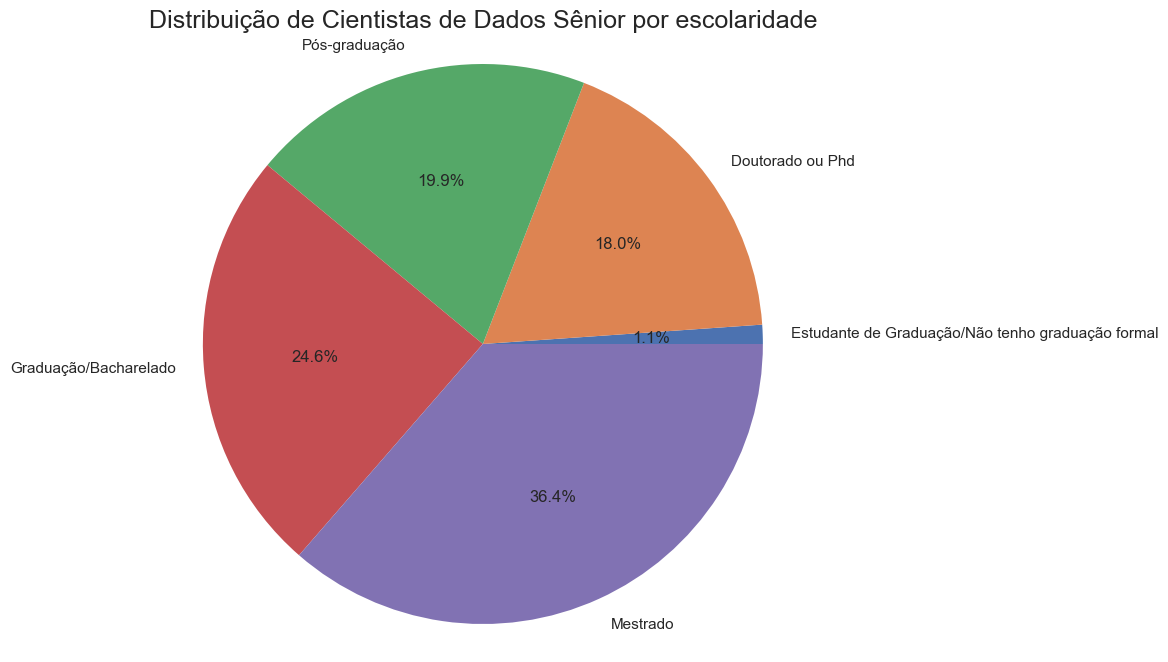

In [22]:
# Plota o gráfico
plt.figure(figsize=(10, 8))
fig = plt.pie(grouped_data["count"], labels=grouped_data["P1_l Nivel de Ensino"], autopct="%1.1f%%")
plt.title("Distribuição de Cientistas de Dados Sênior por escolaridade")
plt.axis("equal")
plt.savefig(OUTPUT_GRAPH+"pie_DS_senior_escolaridade.png")
plt.show()

## 3.2 - Pergunta 12: Qual a faixa salarial por senioridade de analistas e cientistas de dados?
As faixas salarias que mais aparecem por senioridade são:
- Jr : R$**4.001** a R$6.000 para ambos DS e DA.
- Pleno: R$**6.001** a R$**8.000** para DA e R$**8.001** a R$**12.000** para DS
- Senior: R$**8.001** a R$**12.000** para DA e R$**12.001** a R$**16.000** para DS

In [23]:
# Remove cargo de BI Analyst pois não é o foco da pergunta, seleciona as colunas de interesse e agrupa por cargo, nível e faixa salarial. O método size() conta o número de ocorrências de cada combinação de cargo, nível e faixa salarial e o método unstack() reorganiza os dados para que as faixas salariais se tornem colunas
grouped_data = df_targets_ext[~df_targets_ext["P2_f Cargo Atual"].isin(["Analista de BI/BI Analyst"])][["P0 id", "P2_f Cargo Atual", "P2_g Nivel", "P2_h Faixa salarial"]].groupby(["P2_f Cargo Atual", "P2_g Nivel", "P2_h Faixa salarial"]).size().unstack(fill_value=0)


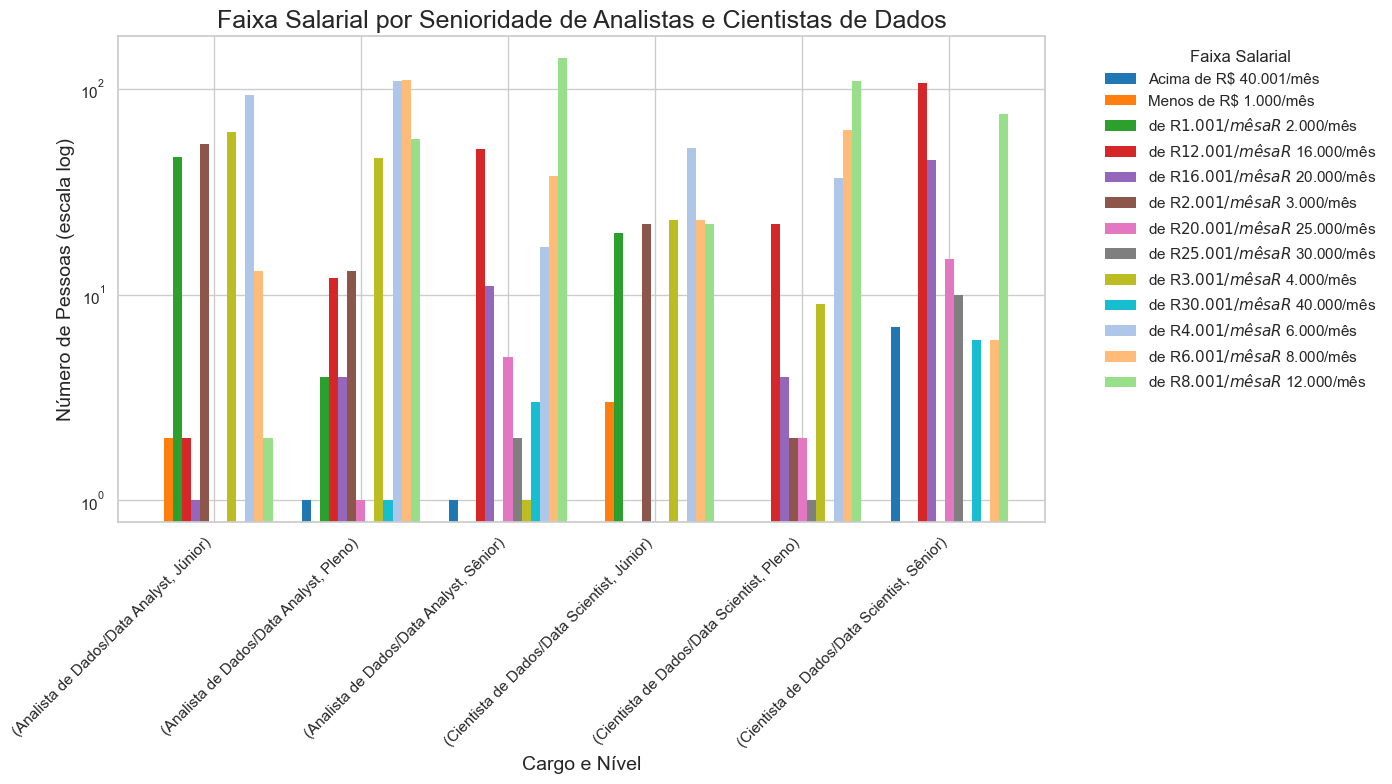

In [24]:
# Plotar o gráfico de barras empilhadas
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#aec7e8", "#ffbb78", "#98df8a"]
fig = grouped_data.plot(kind="bar", figsize=(14, 8), color=colors, width=0.8)
plt.title("Faixa Salarial por Senioridade de Analistas e Cientistas de Dados")
plt.xlabel("Cargo e Nível")
plt.ylabel("Número de Pessoas (escala log)")
# Transforma a escala do eixo y em logaritmo para melhor visualização (diminui a diferença de tamanho entre as barras muito pequenas e as muito grandes)
fig.set_yscale("log")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Faixa Salarial", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(OUTPUT_GRAPH+"bar_faixa_salario.png")
plt.show()

## 4.2 - Visão gestores

In [25]:
# Criar dataset apenas de gestores
df_heads = df_targets_ext[df_targets_ext["P2_d Gestor?"] == 1.0]
df_heads = df_heads.dropna(axis=1, how='all')
df_heads.shape

(0, 0)

# 5 - Exportar DataFrames

In [26]:
# Exportar dataframes para .csv
df_targets.to_csv(OUTPUT_CSV+"data_dataAnalysts.csv", sep=';', decimal=',', index=False)
df_targets_ext.to_csv(OUTPUT_CSV+"data_dataAnalysts_ext.csv", sep=';', decimal=',', index=False)
df_abroad.to_csv(OUTPUT_CSV+"data_abroad.csv", sep=';', decimal=',', index=False)
df_heads.to_csv(OUTPUT_CSV+"data_gestores.csv", sep=';', decimal=',', index=False)
df_prog_langs.to_csv(OUTPUT_CSV+"data_prog_linguagens.csv", sep=';', decimal=',', index=False)
df_prog_langs_ext.to_csv(OUTPUT_CSV+"data_prog_linguagens_ext.csv", sep=';', decimal=',', index=False)
df_prog_langs_target.to_csv(OUTPUT_CSV+"data_prog_linguagens_targets.csv", sep=';', decimal=',', index=False)
df_prog_langs_target_ext.to_csv(OUTPUT_CSV+"data_prog_linguagens_targets_ext.csv", sep=';', decimal=',', index=False)
df_bi_tools.to_csv(OUTPUT_CSV+"data_bi_tools.csv", sep=';', decimal=',', index=False)
df_bi_tools_ext.to_csv(OUTPUT_CSV+"df_bi_tools_ext.csv", sep=';', decimal=',', index=False)
df_bi_tools_targets.to_csv(OUTPUT_CSV+"df_bi_tools_targets.csv", sep=';', decimal=',', index=False)
df_bi_tools_targets_ext.to_csv(OUTPUT_CSV+"df_bi_tools_targets_ext.csv", sep=';', decimal=',', index=False)